In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression   


In [159]:
def invboxcox(y,lmbda):# обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

def get_mape(y_true, y_pred): 
    """
    Вычислить среднюю абсолютную процентную ошибку (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def get_preds_lr(df, target, N, pred_min, offset):
    """
    Получить прогноз на временном интервале t, используя значения из t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe со значениями, которые вы хотите предсказать. Может быть любой длины.
        target     : имя столбца, который вы хотите предсказать, например, 'GMV'.
        N          : получить предсказание на временном интервале t по значениям из t-1, t-2, ..., t-N
        pred_min   : все предсказания должны быть >= pred_min
        offset     : для df мы делаем предсказания только для df[offset:]. например, offset может быть размером обучающего множества
    Outputs
        pred_list  : прогноз для target np.array длины len(df)-offset
    """
    # Создать объект линейной регрессии
    lr = LinearRegression(fit_intercept = True)
    # лист для прогноза 
    pred_list = []
    for i in range(offset, len(df['GMV'])):
        X_train = np.array(range(len(df['GMV'][i-N:i]))) # e.g. [0 1 2 3 4]
        y_train = np.array(df['GMV'][i-N:i]) # e.g. [2944 3088 3226 3335 3436]
        X_train = X_train.reshape(-1, 1)     # e.g X_train = 
                                             # [[0]
                                             #  [1]
                                             #  [2]
                                             #  [3]
                                             #  [4]]
        # X_train = np.c_[np.ones(N), X_train]              # add a column
        y_train = y_train.reshape(-1, 1)
    #     print X_train.shape
    #     print y_train.shape
    #     print 'X_train = \n' + str(X_train)
    #     print 'y_train = \n' + str(y_train)
        lr.fit(X_train, y_train)            # Обучение модели

        prediction = lr.predict(np.array(N).reshape(1,-1))
        #print(prediction)
        pred_list.append(prediction[0][0])  # Прогнозируйте количество шагов с помощью модели
    
    # If the values are < pred_min, set it to be pred_min
        
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list

# Преобразование исходных данных 

In [117]:
# загрузка dataset
db_ = pd.read_csv('Данные/DT_MART/Sales.csv','\t',parse_dates=['Date'], index_col='Date', dayfirst=True, low_memory = False) #1,048,575 
df2 = db_.sort_index() # сортировка 

In [118]:
# преобразование данных, очистка пустых значений и изменение типа  
df2.replace(' ', np.nan, inplace=True) #1,046,133
df2.replace(0.0, np.nan, inplace=True) #1,045,311
df2 = df2.dropna()
df2["GMV"] = pd.to_numeric(df2["GMV"])

#unique_arr = db3["SLA"].unique() # групировка содержимых значений 

# удаление не нужных атрибутов  
df2.drop(['ID_Order','ID_Item_ordered','Product_Category', 'Sub_category','Procurement_SLA'],axis=1, inplace=True)

# переименование 
df2['Category'],df2['Brand'],df2['Units'] = df2['Analytic_Category'],df2['product_analytic_vertical'],df2['Units_sold']
df2.drop(['Analytic_Category','product_analytic_vertical','Units_sold'], axis=1, inplace=True)

In [119]:
# конечный вид данных  
df2 = df2[['ID','Category','Brand','GMV','MRP','Units','SLA']]
df2.info()

#Сохранение нового файла 
df2.to_csv('SalesX_.csv', sep=';', encoding='utf-8')

# Загрузка преобразованных данных 
GMV - Общий объем оборота товаров
https://ru.wikipedia.org/wiki/Общий_объём_оборота_товаров#:~:text=GMV)%20–%20термин%2C%20применяемый%20в,площадку%20за%20определенный%20период%20времени.&text=Например%2C%20если%20компания%20реализует%2010,рассматривается%20как%20показатель%20валовой%20выручки.

MRP – Предельный продукт в денежном выражении, который рассчитывается по формуле: MRP = MP * MR,
где МР – предельный продукт ресурса, МR – предельный доход от продажи дополнительной единицы продукции
https://kpfu.ru/docs/F1241829507/tema.7.pdf

Discount - представляет уступку, сбавку, скидку.

In [131]:
# загрузка dataset
db = pd.read_csv('SalesX.csv',';', parse_dates=['Date'], index_col='Date', dayfirst=True, low_memory = False) #1,045,311

In [132]:
df2 = db
#df2.info()
df2.head()

,ID,Category,Brand,GMV,MRP,Units,SLA
Date,,,,,,,
2015-08-30 13:17:00,ACCE7U2GBCJKQZZV,CameraAccessory,Lens,285.0,395,1,16
2015-09-14 16:06:00,AUDEAFDA5GGESPWX,EntertainmentSmall,AudioMP3Player,299.0,999,1,8
2015-09-15 13:06:00,ACCDH7MFZJGRWJCW,GamingHardware,GamePad,284.0,410,1,5
2015-09-22 11:26:00,VGLE7AUXCYJWGBRV,EntertainmentSmall,VideoGlasses,419.0,349,1,9
2015-09-22 17:17:00,REME69QDWFWZGUMB,EntertainmentSmall,RemoteControl,490.0,999,1,8


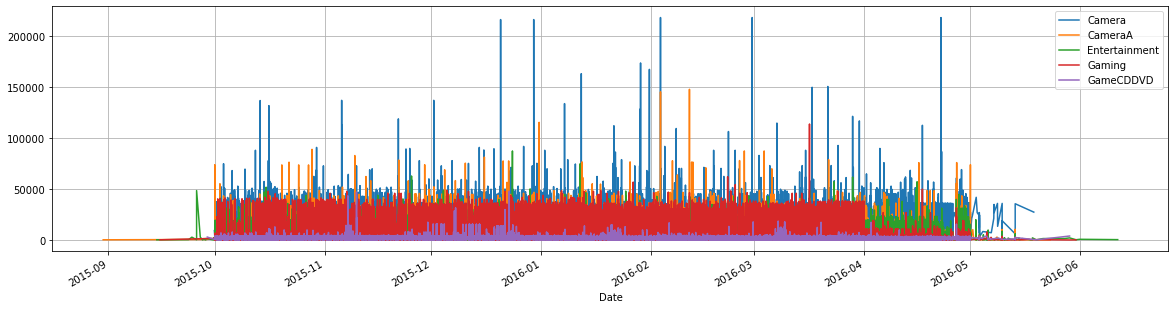

In [133]:
# 5 категории товаровов, 74 вида товара 
df_Camera = df2[df2.Category == 'Camera'] #5 
df_CameraA = df2[df2.Category == 'CameraAccessory'] #25
df_Entertainment = df2[df2.Category == 'EntertainmentSmall'] #23
df_Gaming = df2[df2.Category == 'GamingHardware'] #18
df_GameCDDVD = df2[df2.Category == 'GameCDDVD'] #3

# график 
df_Camera['GMV'].plot(figsize=(15,5), label="Camera", grid=True)
df_CameraA['GMV'].plot(figsize=(15,5),label="CameraA",grid=True)
df_Entertainment['GMV'].plot(figsize=(15,5),label="Entertainment",grid=True)
df_Gaming['GMV'].plot(figsize=(15,5),label="Gaming",grid=True)
df_GameCDDVD['GMV'].plot(figsize=(20,5),label="GameCDDVD",grid=True)
plt.legend(loc = 'best')

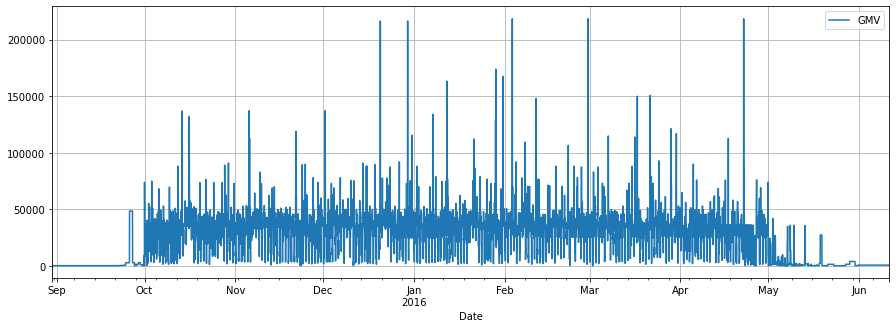

In [134]:
# Объем продаж (усредненные) с 2015-2016г за каждый час
df = df2[['GMV']].resample('h').max() #last() first() min() max() mean()
df = df.fillna(method='ffill')
df.plot(figsize=(15,5),label="GMV")
plt.grid(True)

In [135]:
df = df2[['GMV','MRP','SLA','Units']].resample('h').max()
df = df.fillna(method='ffill')
df = df.dropna()

df = pd.DataFrame({'GMV': df.GMV/10,'MRP': df.MRP/10,
                   'SLA': df.SLA,'Units': df.Units
                   })
#df

count     6863.000000
mean      2516.652557
std       1979.410563
min         12.900000
25%        285.000000
50%       3049.000000
75%       3663.900000
max      21850.000000
Name: GMV, dtype: float64
V = 0.786525


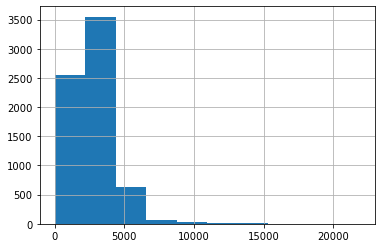

In [136]:
itog_GMV = df.GMV.describe()
print(itog_GMV)
df['GMV'].hist()
print ('V = %f' % (itog_GMV['std']/itog_GMV['mean']))

In [137]:
#Описательная статистика
print(df.describe())
print()
print(df.corr()) #корреляционная матрица

                GMV           MRP          SLA        Units
count   6863.000000   6863.000000  6863.000000  6863.000000
mean    2516.652557   3455.842168    13.033950     2.311088
std     1979.410563   2505.382678     5.751523     2.376866
min       12.900000      0.000000     0.000000     1.000000
25%      285.000000    443.300000    10.000000     1.000000
50%     3049.000000   4499.500000    14.000000     2.000000
75%     3663.900000   5000.000000    16.000000     2.000000
max    21850.000000  28000.000000   184.000000    50.000000

            GMV       MRP       SLA     Units
GMV    1.000000  0.941769  0.428872  0.373470
MRP    0.941769  1.000000  0.443320  0.360901
SLA    0.428872  0.443320  1.000000  0.291250
Units  0.373470  0.360901  0.291250  1.000000


In [138]:
j = 0
l = []
for i in range(0, 6863):
    if df.GMV[i] > 8000:
        df.replace(df.GMV[i], np.nan, inplace=True)
        df.fillna(method='ffill',inplace=True )
        #df.replace(df.GMV[i], df.GMV[i]*100, inplace=True)
        j+=1
        l.append(i)
#df = df.dropna()

count    6863.000000
mean     2452.123386
std      1764.706038
min        12.900000
25%       285.000000
50%      3030.000000
75%      3650.000000
max      7899.900000
Name: GMV, dtype: float64
V = 0.719664


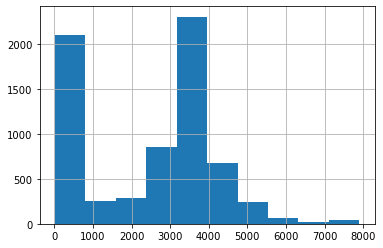

In [139]:
itog_GMV = df.GMV.describe()
print(itog_GMV)
df['GMV'].hist()
print ('V = %f' % (itog_GMV['std']/itog_GMV['mean']))

In [140]:
'''ximport sesd
ts = df.GMV
list_idx1 = []
list_idx2 = []
# Introduce artificial anomalies
outliers_indices = sesd.seasonal_esd(ts, hybrid=True, max_anomalies=44)
for idx in outliers_indices:
    #print(f'Anomaly index: {idx}, anomaly value: {ts[idx]}')
    list_idx1.append(idx)
    list_idx2.append(ts[idx])
    df.replace(ts[idx], np.nan, inplace=True)
    df.fillna(method='ffill',inplace=True )
    
#df.drop(df.index[list_idx], axis=0, inplace=True)# удаление выбросов
#df.replace(list_idx2, np.nan, inplace=True)
#df = df.fillna(method='bfill')
'''

"ximport sesd\nts = df.GMV\nlist_idx1 = []\nlist_idx2 = []\n# Introduce artificial anomalies\noutliers_indices = sesd.seasonal_esd(ts, hybrid=True, max_anomalies=44)\nfor idx in outliers_indices:\n    #print(f'Anomaly index: {idx}, anomaly value: {ts[idx]}')\n    list_idx1.append(idx)\n    list_idx2.append(ts[idx])\n    df.replace(ts[idx], np.nan, inplace=True)\n    df.fillna(method='ffill',inplace=True )\n    \n#df.drop(df.index[list_idx], axis=0, inplace=True)# удаление выбросов\n#df.replace(list_idx2, np.nan, inplace=True)\n#df = df.fillna(method='bfill')\n"

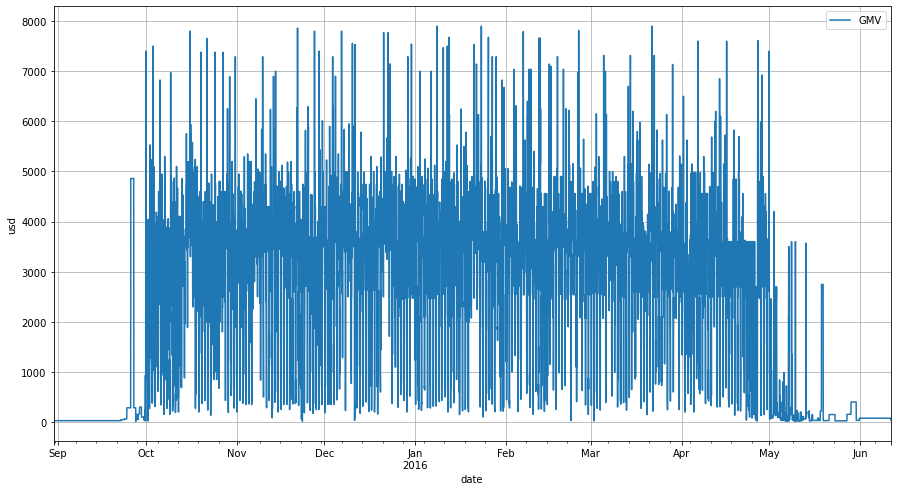

In [141]:
df['GMV'].plot(figsize=(15,8), grid = True)
#df.plot(figsize=(15,5),label="GMV")
plt.legend(loc = 'best')
plt.xlabel("date")
plt.ylabel("usd")
plt.grid(True)

Text(0.5, 0.98, 'Multiplicative Decomposition')

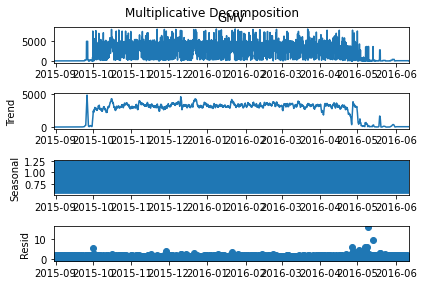

In [142]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_results = seasonal_decompose(df.GMV, model="multiplicative")
decomposition_results.plot().suptitle("Multiplicative Decomposition", fontsize=12)

In [143]:
test = sm.tsa.adfuller(df['GMV'])
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values:', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.429837870150992
p-value:  0.009982793824942437
Critical values: {'1%': -3.431307657594668, '5%': -2.8619632060722413, '10%': -2.5669952688059707}
единичных корней нет, ряд стационарен


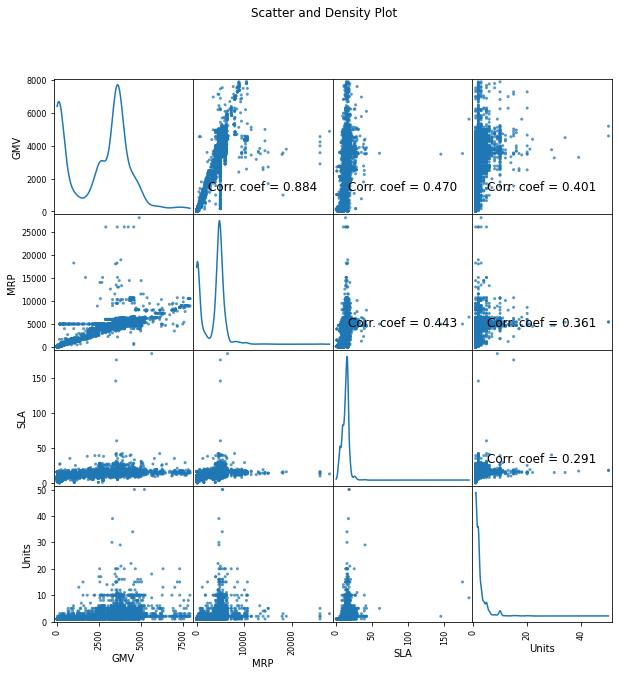

In [144]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.5, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()
    
plotScatterMatrix(df, 10, 12)

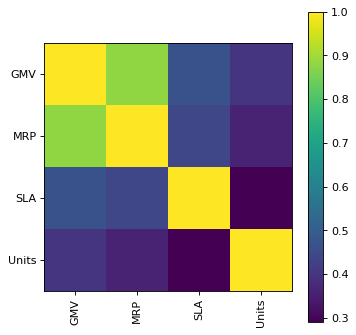

In [145]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    #filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr,fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    #plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()
    
plotCorrelationMatrix(df, 5)

Оптимальный параметр преобразования Бокса-Кокса: 0.521195
Критерий Дики-Фуллера: p=0.026532 < 0.05


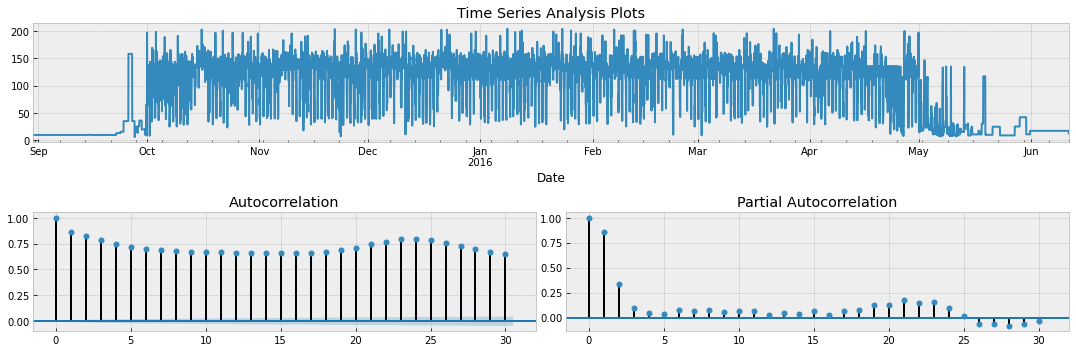

In [146]:
from statsmodels.iolib.table import SimpleTable
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
def tsplot(y, lags=None, figsize=(15, 5), style='bmh'): # Критерий Дики-Фуллера
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        plt.tight_layout()
        
        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1],'< 0.05')

    return

df['GMV_'] = df['GMV']
df['GMV'], lmbda = scs.boxcox(df.GMV)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
tsplot(df.GMV, lags=30)
#df.drop(['GMV1'], axis=1, inplace=True)

In [147]:
#df['GMV_1'] = df.GMV1 - df.GMV1.shift(24)
#tsplot(df.GMV_1[24:], lags=30)
#df.drop(['GMV2'], axis=1, inplace=True)
#df = df[24*7:]

count    6863.000000
mean       96.960778
std        54.571476
min         5.356346
25%        34.594825
50%       123.254560
75%       136.008629
max       204.344666
Name: GMV, dtype: float64
V = 0.562820


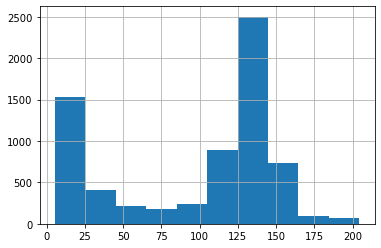

In [148]:
itog_GMV = df.GMV.describe()
df.GMV.hist()
print(itog_GMV)
print ('V = %f' % (itog_GMV['std']/itog_GMV['mean']))

In [149]:
df

,GMV,MRP,SLA,Units,GMV_
Date,,,,,
2015-08-30 13:00:00,9.077921,39.5,16.0,1.0,28.5
2015-08-30 14:00:00,9.077921,39.5,16.0,1.0,28.5
2015-08-30 15:00:00,9.077921,39.5,16.0,1.0,28.5
2015-08-30 16:00:00,9.077921,39.5,16.0,1.0,28.5
2015-08-30 17:00:00,9.077921,39.5,16.0,1.0,28.5
...,...,...,...,...,...
2016-06-11 07:00:00,16.653395,129.9,9.0,1.0,77.9
2016-06-11 08:00:00,16.653395,129.9,9.0,1.0,77.9
2016-06-11 09:00:00,16.653395,129.9,9.0,1.0,77.9


In [150]:
# добавление доп. признаков
df["date"] = df.index.date
#df["hour"] = df.index.hour
#df["day"] = df.index.day
#df["weekday"] = df.index.weekday
#df['is_weekend'] = df.weekday.isin([5,6])*1
#df["month"] = df.index.month
#df = df.drop(["weekday"],1)
# Вычислим разницу между 
df['range_mg'] = df.MRP - df.GMV_ 
#df.drop(['Units'], axis=1, inplace=True)
df.head()

,GMV,MRP,SLA,Units,GMV_,date,range_mg
Date,,,,,,,
2015-08-30 13:00:00,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0
2015-08-30 14:00:00,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0
2015-08-30 15:00:00,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0
2015-08-30 16:00:00,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0
2015-08-30 17:00:00,9.077921,39.5,16.0,1.0,28.5,2015-08-30,11.0


# Разделить на test, cv и test набор
Разделим этот набор данных на 60% train, 20% validation и 20% test

In [151]:
# Количество train, cv, test наборов данных

test_size = 0.3                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test

n_cv, n_test = int(cv_size*len(df)), int(test_size*len(df))
n_train =  len(df) - n_cv - n_test
print('Количество:')
print(" n_train = " + str(n_train),
        "\n n_cv = " + str(n_cv), 
        "\n n_test = " + str(n_test))


# Разделить на train, cv, and test
train = df[:n_train].copy()
cv = df[n_train:n_train+n_cv].copy()
train_cv = df[:n_train+n_cv].copy()
test = df[n_train+n_cv:].copy()
print('Размерность:')
print(" train = " + str(train.shape),
        "\n cv = " + str(cv.shape), "~ train_cv = " + str(train_cv.shape),
        "\n test = " + str(test.shape))

Количество:
 n_train = 3433 
 n_cv = 1372 
 n_test = 2058
Размерность:
 train = (3433, 7) 
 cv = (1372, 7) ~ train_cv = (4805, 7) 
 test = (2058, 7)


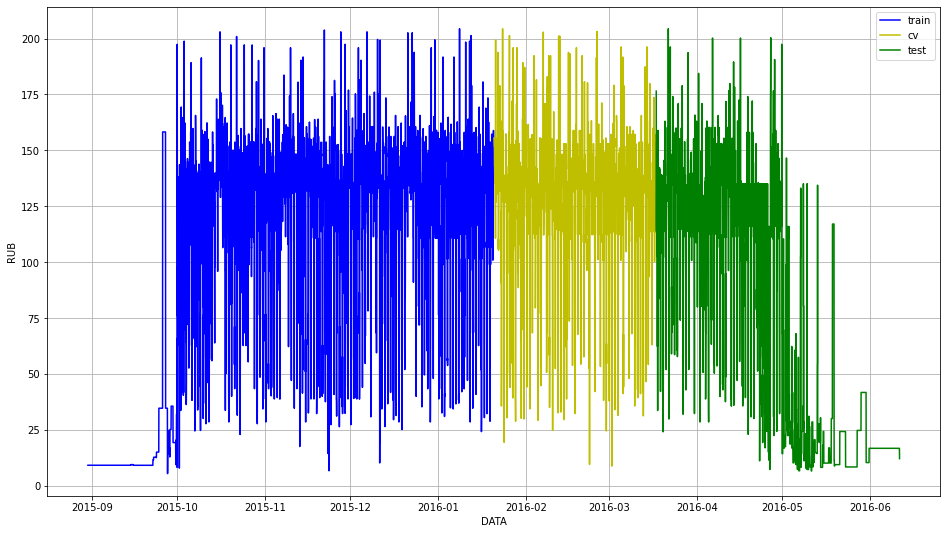

In [152]:
# График деление на train, cv, и test
plt.figure(figsize=(16, 9))
plt.plot(train.GMV, 'b',label = 'train')
plt.plot(cv.GMV, 'y',label= 'cv')
plt.plot(test.GMV, 'g',label= 'test')
plt.legend(loc='best')
plt.xlabel("DATA")
plt.ylabel("RUB")
plt.grid(True)

# Простая линенная регрессия
Прогноз 

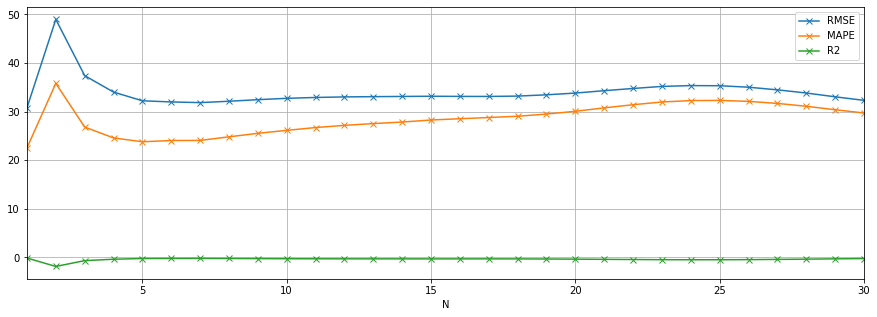

In [153]:
RMSE, R2, MAPE = [],[],[]
# N is no. of samples to use to predict the next value
for N in range(1, Nmax+1): 
                           #(df, target, N, pred_min, offset):
    LR,pred_list = get_preds_lr(train_cv, 'GMV', N, 0, n_train)
    # добавляем прогноз исходного ряда в качестве признаков
    cv.loc[:, 'pred_' + str(N)] = pred_list
    
    #append
    RMSE.append(math.sqrt(mean_squared_error(cv.GMV, pred_list)))
    MAPE.append(get_mape(cv.GMV, pred_list))
    R2.append(r2_score(cv.GMV, pred_list))
    
#print('RMSE = ' + str(RMSE))
#print('MAPE = ' + str(MAPE))
#print('R2 = ' + str(R2))

# График качества прогноза на проверочных данных cv  
plt.figure(figsize=(15, 5))
plt.plot(range(1, Nmax+1), RMSE, 'x-',label="RMSE" )
plt.plot(range(1, Nmax+1), MAPE, 'x-',label="MAPE")
plt.plot(range(1, Nmax+1), R2, 'x-',label="R2")
plt.xlabel('N')
plt.xlim([1, Nmax])
plt.legend(loc = 'best')
plt.grid(True)

In [154]:
max(RMSE)
R2

[-0.13315501375183536,
 -1.8721412716318464,
 -0.6746333114794776,
 -0.3850206462771102,
 -0.24292627635725217,
 -0.22469668567188905,
 -0.2141241047917528,
 -0.23573570497667773,
 -0.2606278326878406,
 -0.2824081645735266,
 -0.29631411168715527,
 -0.30526825317227857,
 -0.30941649349880107,
 -0.31275984353633346,
 -0.3159667930370085,
 -0.313547118215711,
 -0.312759188569248,
 -0.31868288338187156,
 -0.33972654808281333,
 -0.36834803519849224,
 -0.4086972289472144,
 -0.4460898750230957,
 -0.48171939205559,
 -0.4957978433380754,
 -0.49346847706026487,
 -0.4679890792618324,
 -0.42268952446704167,
 -0.3696700073231174,
 -0.30694801875365574,
 -0.2501240946883061]

In [155]:
# Set optimum N
N_opt = 6

R2 on train set = -0.231


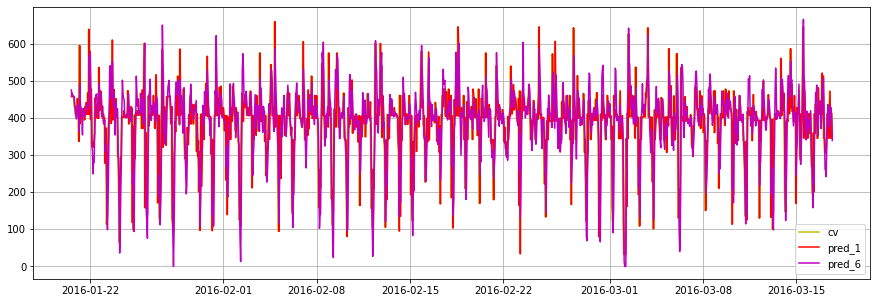

In [235]:
# Plot adjusted close over time
plt.figure(figsize=(15, 5))

#plt.plot(train.GMV, 'b',label='train' )
plt.plot(c, 'y',label='cv' )
#plt.plot(test.GMV, 'g',label='test' )
plt.plot(cv.pred_1, 'r',label='pred_1' )
plt.plot(cv.pred_6, 'm',label='pred_6' )
plt.legend(loc = 'best')
plt.grid(True)
print("R2 on train set = {:.4}".format(r2_score(cv.GMV, cv.pred_6)))

# final model

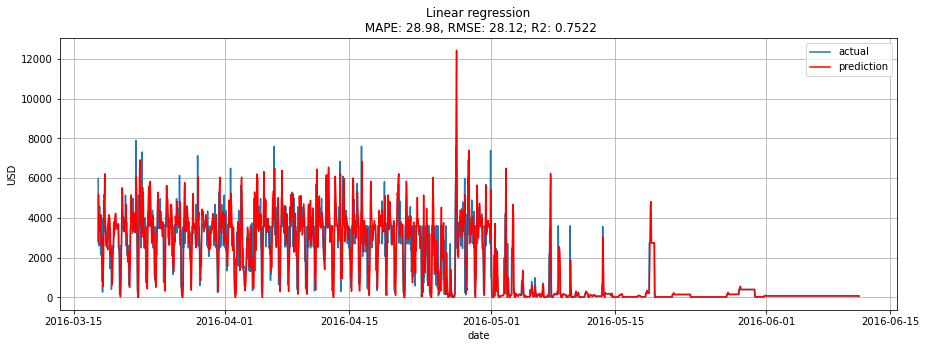

In [160]:
                        #(df, target, N, pred_min, offset):
pred_list = get_preds_lr(df, 'GMV', N_opt, 0, n_train+n_cv)
test.loc[:, 'pred_' + str(N_opt)] = pred_list

pred_df = pd.DataFrame({'pred_list': pred_list.reshape(-1), 
                       'Date': df[n_train+n_cv:]['date']})

# График прогноза
pred_df["pred_list_"] = invboxcox(pred_df.pred_list, lmbda)

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(test.GMV_, label="actual" )
plt.plot(pred_df.pred_list_,'r' ,label="prediction")
plt.legend(loc = 'best')
plt.xlabel("date")
plt.ylabel("USD")
plt.title("Linear regression\n MAPE: {:.4}, RMSE: {:.4}; R2: {:.4}".format(
    get_mape(test.GMV,pred_df.pred_list),
    np.sqrt(mean_squared_error(test.GMV, pred_df.pred_list)),
    r2_score(test.GMV, pred_df.pred_list)))
plt.grid(True)

In [161]:
print("MAPE on train set = {:.4}".format(get_mape(test.GMV, pred_list)))
print("RMSE on train set = {:.4}".format(math.sqrt(mean_squared_error(test.GMV, pred_list))))
print("R2 on train set = {:.4}".format(r2_score(test.GMV, pred_list)))

MAPE on train set = 28.98
RMSE on train set = 28.12
R2 on train set = 0.7522


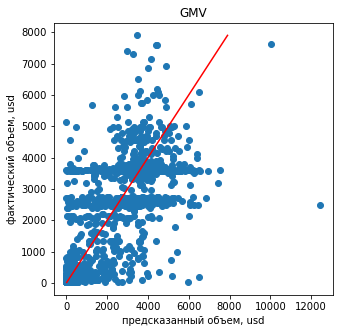

In [163]:
plt.figure(figsize=(5, 5))
plt.scatter(pred_df.pred_list_,test.GMV_)
plt.title("GMV")
plt.ylabel('фактический объем, usd')
plt.xlabel('предсказанный объем, usd')
plt.plot([test.GMV_.min(), test.GMV_.max()],[[test.GMV_.min()],[test.GMV_.max()]], color = 'red')

In [566]:
itog_model = pd.DataFrame({'LR': pred_df.pred_list_})
#Сохранение нового файла 
itog_model.to_csv('itog_model_LR.csv', sep=';', encoding='utf-8')

In [58]:
LR.n_jobs